# import

In [166]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

np.set_printoptions(linewidth=200)
pd.set_option('display.max_rows', 100)

# タスクの概要

**目標**　患者の11の特徴から心臓病か否かを分類する。

データは、`data`ディレクトリに`train.csv`, `test.csv`という名前のデータがあります。記録されている特徴量は以下のとおりです。学習モデルを作るときには、`train.csv`のみを用いてよいものとします。以下の2つのことに挑戦してください。

1. 心臓病になりやすい患者さんとはどんなひとかを説明してください。
2. デモでみせるモデルよりも`test.csv`の上で精度の高いモデルを作ってください。

# 特徴量

* Age : 患者の年齢
* Sex : 患者の性別
    * `1`は男性, `0`は女性
* ChestPainType : 筋痛の種類
    * `TA`は典型的狭心症, `ATA`は非典型狭心症, `NAP`は非狭心症の痛み, `ASY`は無症状
* RestingBP : 安静時血圧
* Cholesterol : 血清コレステロール値
* FastingBS : 空腹時血糖値
    * `1`は~FastingBS>1~`>120 mg/dl`, `0`はそれ以外
* RestingECG : 安静時心電図結果
    * `Normal`は正常, `ST`はST-T波に異常, `LVH`は左心室肥大の可能性・確定
* MaxHR : 到達最大心拍数
* ExerciseAngina : 運動誘発性狭心症
    * `1`はあり, `0`はなし
* Oldpeak : ~うつ状態で測定された数値~　安静時と比較して運動により誘発されたST低下
* ST_Slope : 運動時のSTピークセグメントの動き
    * `Up`はupsloping, `flat`は平坦, `Down`はdownsloping

心臓病かいなかは`HeartDisease`に`1`が心臓病, `0`が正常として記録されています。

# データの概観

In [241]:
df_orig = pd.read_csv('./data/train.csv')

In [324]:
df = df_orig.copy()
display(df.head())

print(df.isna().sum())

# 目的変数を分離する
df_y = df['HeartDisease']
df = df.drop(columns='HeartDisease')

# Cholesterol列の0をNaNに変換する
df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = np.nan

# One-Hotエンコーディングする(冗長な列も残しておく)
df = pd.get_dummies(df, drop_first=False)

# 目的変数を先頭に結合する
df.insert(loc=0, column='HeartDisease', value=df_y)
display(df.head())
print(df.shape)

print(df.isna().sum())

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


,HeartDisease,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,1,56,1,155,342.0,1,150,1,3.0,1,0,0,0,0,1,0,0,1,0
1,0,55,0,130,394.0,0,150,0,0.0,0,1,0,0,1,0,0,0,0,1
2,1,47,1,110,NaN,1,120,1,0.0,0,0,1,0,0,1,0,0,1,0
3,1,34,1,115,NaN,1,154,0,0.2,1,0,0,0,0,1,0,0,0,1
4,0,54,0,160,201.0,0,163,0,0.0,0,0,1,0,0,1,0,0,0,1


(642, 19)
HeartDisease           0
Age                    0
Sex                    0
RestingBP              0
Cholesterol          123
FastingBS              0
MaxHR                  0
ExerciseAngina         0
Oldpeak                0
ChestPainType_ASY      0
ChestPainType_ATA      0
ChestPainType_NAP      0
ChestPainType_TA       0
RestingECG_LVH         0
RestingECG_Normal      0
RestingECG_ST          0
ST_Slope_Down          0
ST_Slope_Flat          0
ST_Slope_Up            0
dtype: int64


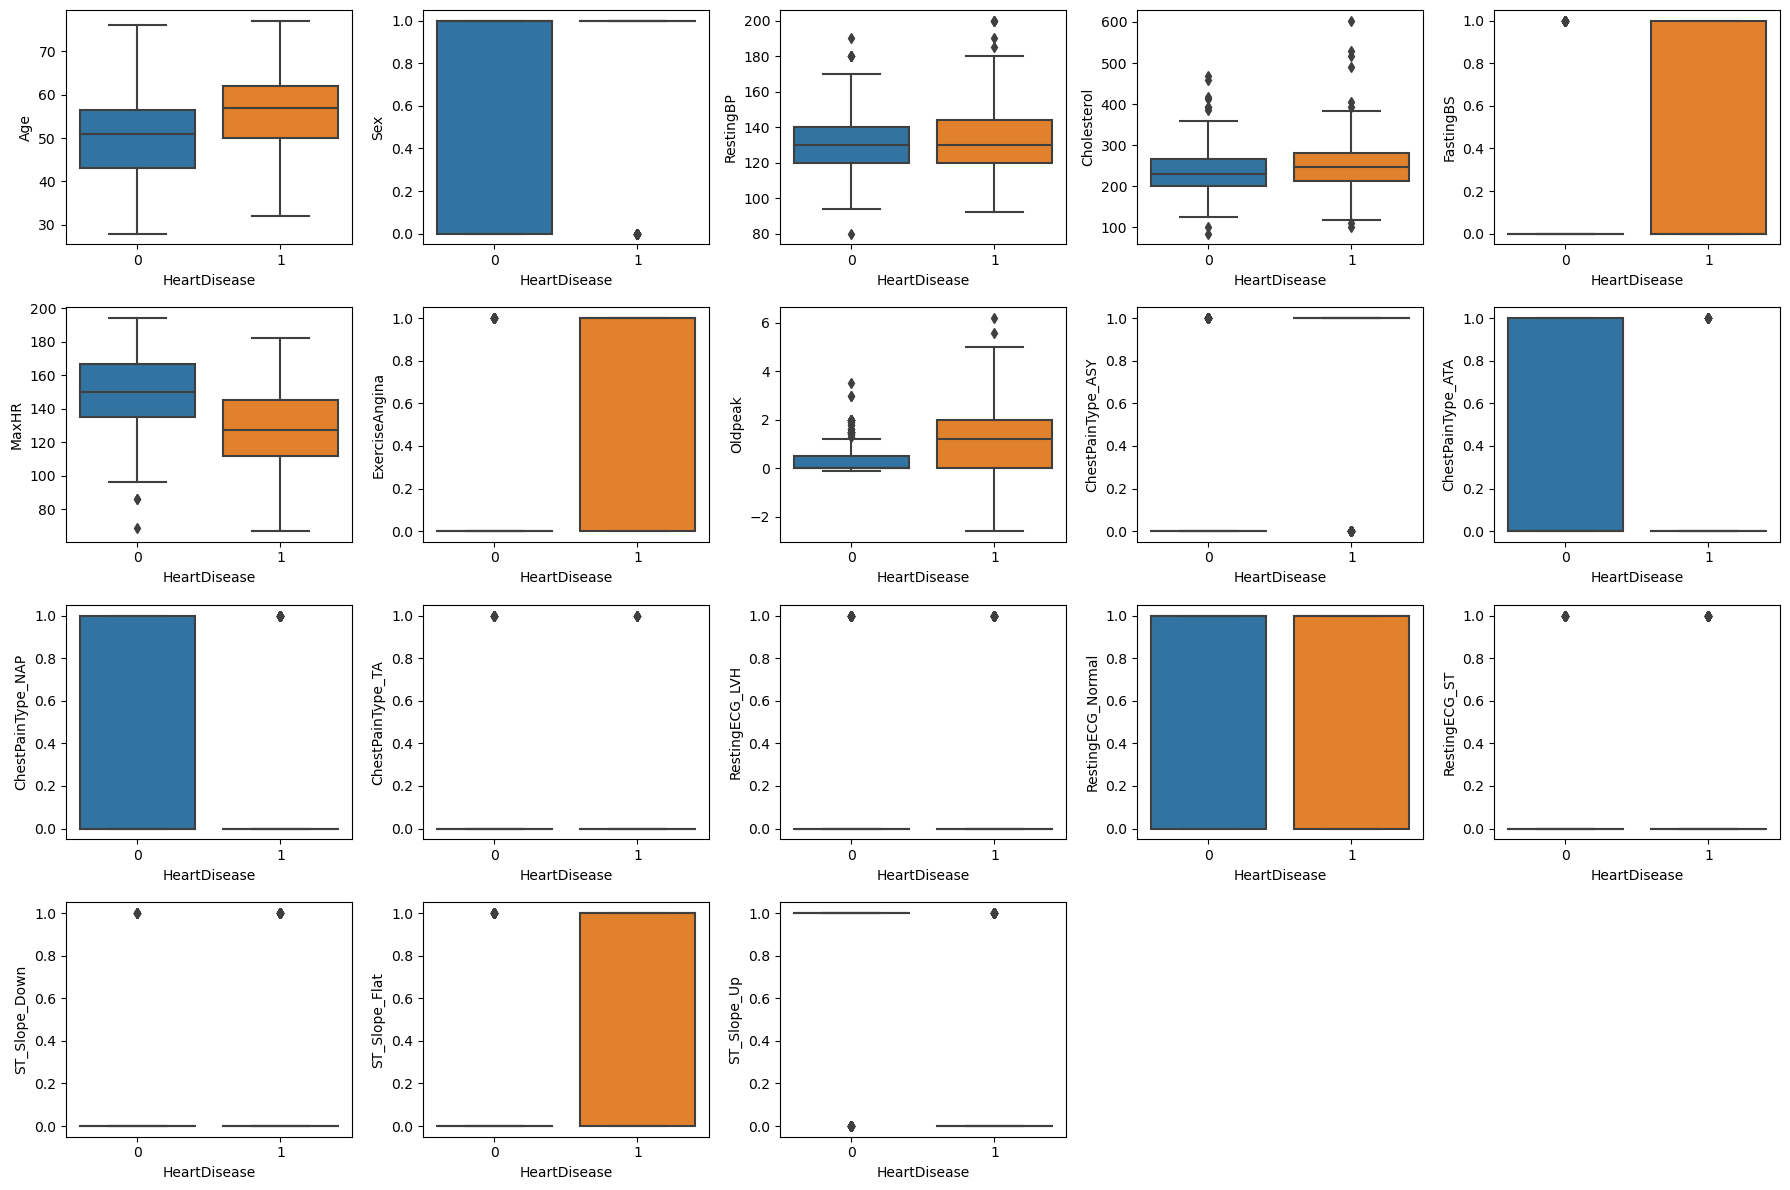

In [322]:
# 良性/悪性で分けた箱ヒゲ図を描く
fig =plt.figure(figsize=[18,12])
for i in range(0, df.shape[1]-1):
    axi = plt.subplot(4, 5, i+1)
    sns.boxplot(x=df.iloc[:, 0], y=df.iloc[:, i+1], data=df, ax=axi)
    plt.tight_layout() # 体裁をきれいにするおまじない
plt.show()

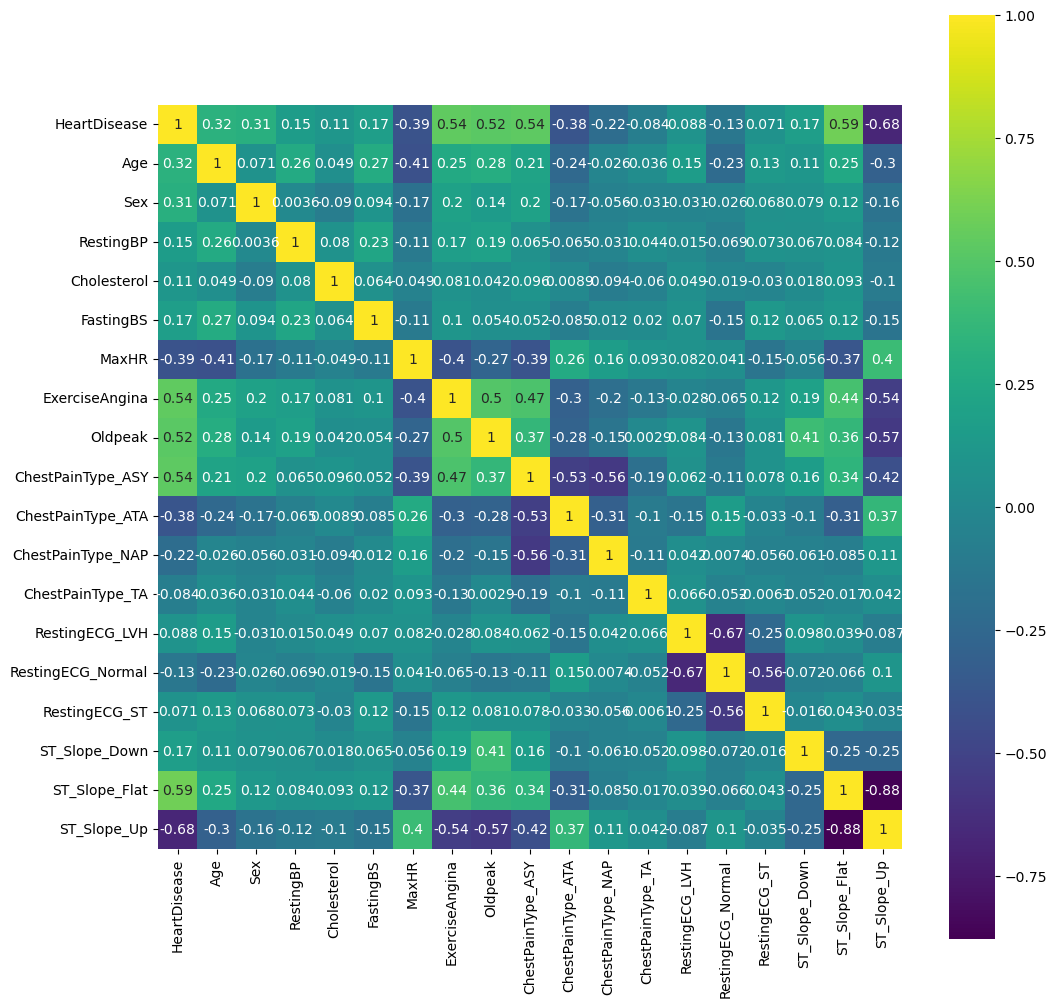

In [328]:
cm = np.corrcoef(df.dropna(how='any').values.T)

plt.figure(figsize = (12, 12))
heat_map = sns.heatmap(cm, xticklabels=df.columns, yticklabels=df.columns, cmap='viridis', annot=True, square=True)

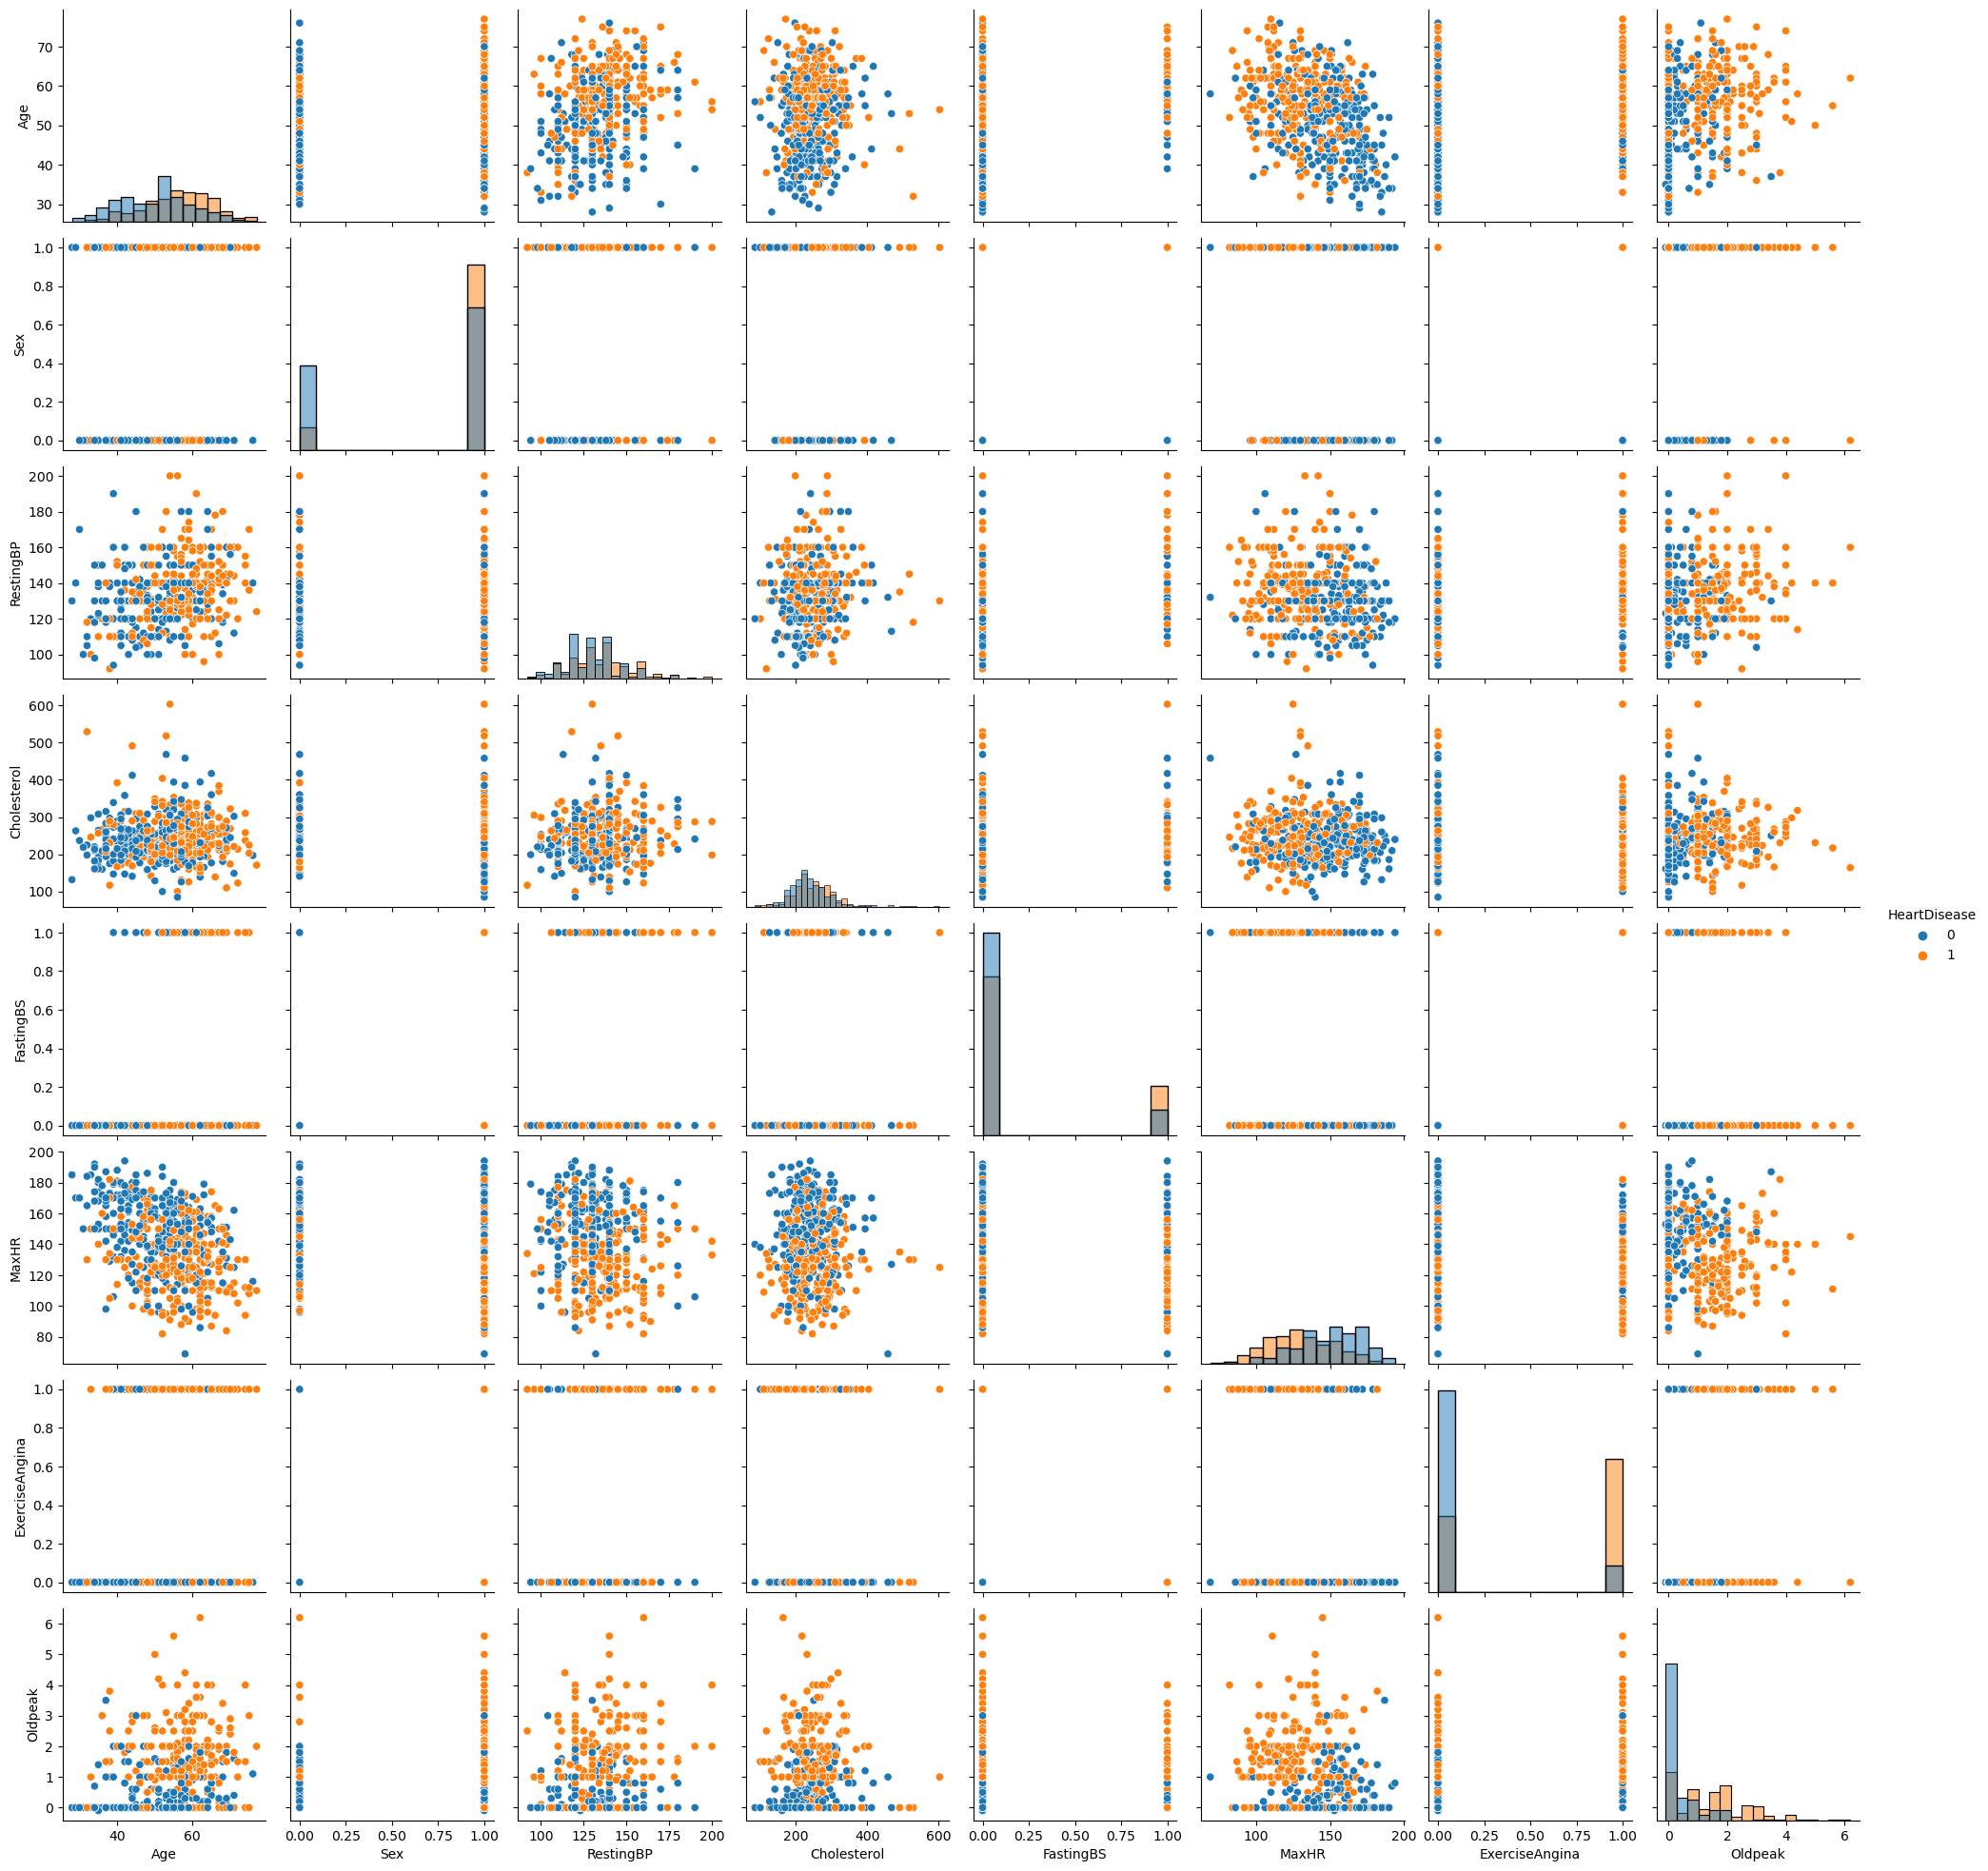

In [349]:
sns.pairplot(data=df.iloc[:, :9],diag_kind="hist", hue='HeartDisease')
plt.show()

In [350]:
df.describe()

,HeartDisease,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_ST,ST_Slope_Down,ST_Slope_Up
count,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000
mean,0.477842,53.069364,0.753372,133.015414,243.414258,0.171484,140.221580,0.364162,0.889017,0.223507,0.246628,0.036609,0.227360,0.169557,0.065511,0.470135
std,0.499991,9.629177,0.431464,17.284240,59.626572,0.377295,24.261666,0.481659,1.092134,0.416997,0.431464,0.187981,0.419532,0.375605,0.247663,0.499589
min,0.000000,28.000000,0.000000,92.000000,85.000000,0.000000,69.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,46.000000,1.000000,120.000000,208.000000,0.000000,122.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,54.000000,1.000000,130.000000,235.000000,0.000000,140.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,60.000000,1.000000,140.000000,274.000000,0.000000,160.000000,1.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,77.000000,1.000000,200.000000,603.000000,1.000000,194.000000,1.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 前処理

In [372]:
# 説明変数と目的変数を決める
# df = df.drop(columns=['ChestPainType_ASY', 'RestingECG_Normal', 'ST_Slope_Flat'])
df = df.dropna()

cols = df.iloc[:, 1:].columns
# cols = ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak']
# cols = ['FastingBS', 'Cholesterol']
# cols = ['Cholesterol', 'Oldpeak']
# cols = ['MaxHR', 'ExerciseAngina']
y = df['HeartDisease'].values
X = df.drop(columns='HeartDisease').values

# 学習用データとテスト用データに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [373]:
# 標準化する
sscaler = StandardScaler()
X_train_ss = sscaler.fit_transform(X_train)
X_test_ss = sscaler.fit_transform(X_test)

# 特徴量を減らす

## 特徴量選択

### L1正則化したロジスティック回帰
[# ロジスティック回帰(限界がある)](#ロジスティック回帰(限界がある))

### 決定木

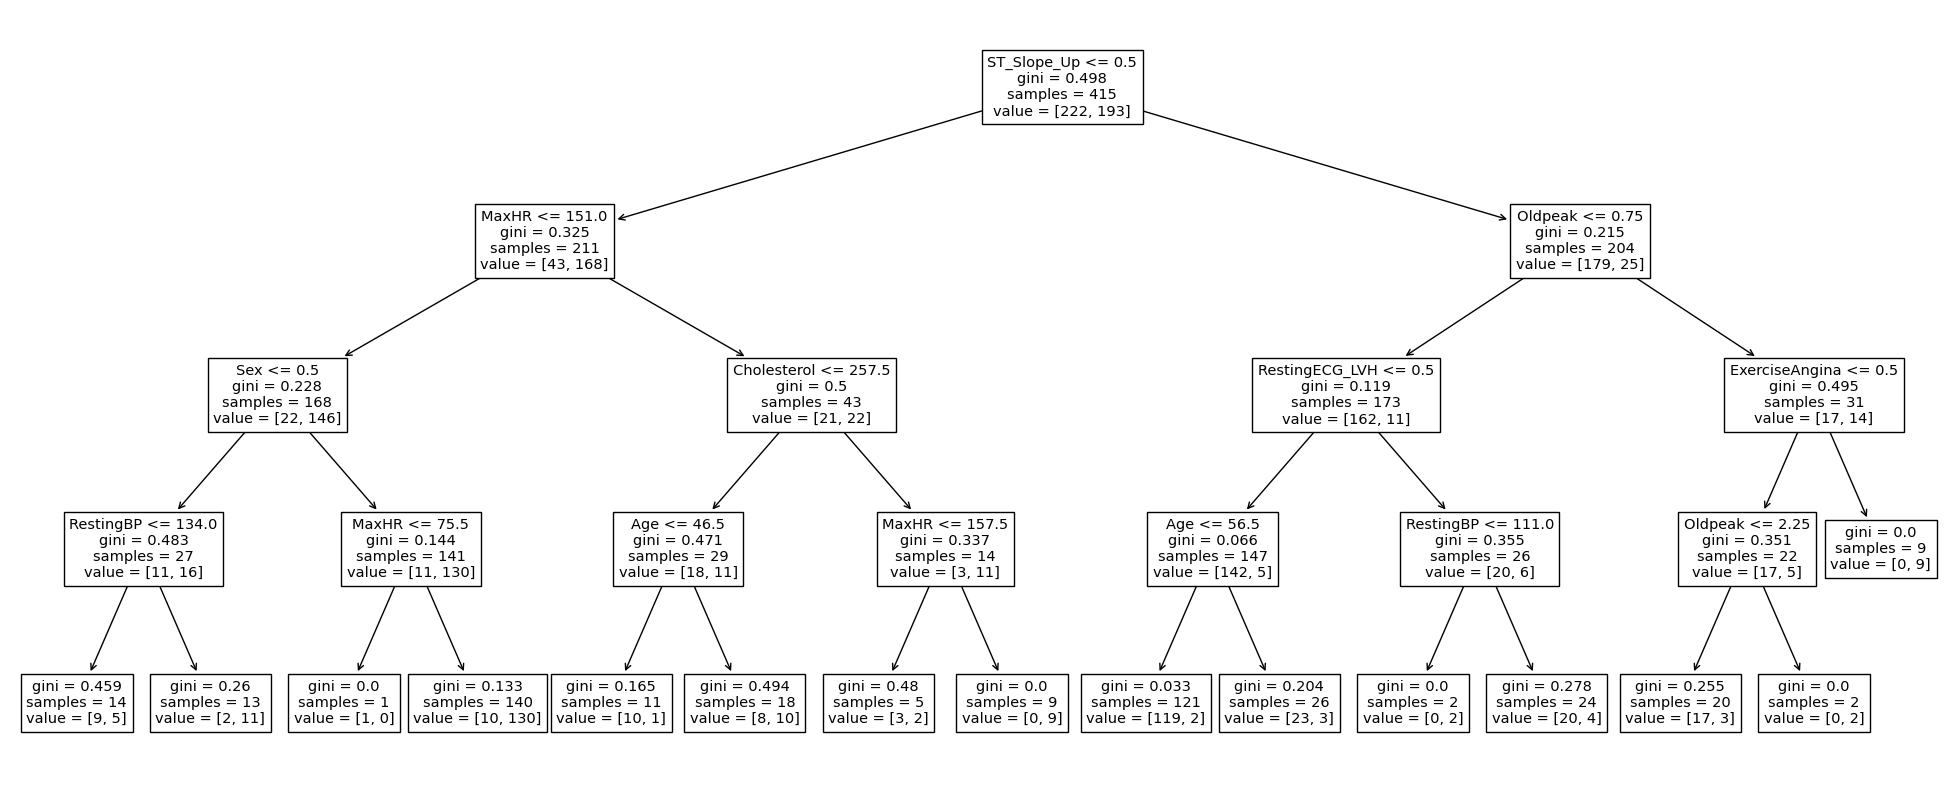

In [377]:
tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

plt.figure(figsize=(25, 10))
tree.plot_tree(tree_model, feature_names=cols, fontsize=10.5)
plt.show()

### ランダムフォレストで特徴量の重要度を評価する

## 特徴量抽出

# ロジスティック回帰(限界がある)

       - 'lbfgs'           -   ['l2', None]
       - 'liblinear'       -   ['l1', 'l2']
       - 'newton-cg'       -   ['l2', None]
       - 'newton-cholesky' -   ['l2', None]
       - 'sag'             -   ['l2', None]
       - 'saga'            -   ['elasticnet', 'l1', 'l2', None]

学習用データでの正解率: 0.5590361445783133
切片: [-0.037623]


,変数名,係数
0,FastingBS,-0.205524
1,Cholesterol,-0.227322


係数: [[-0.20552375 -0.22732196]]
['FastingBS', 'Cholesterol']


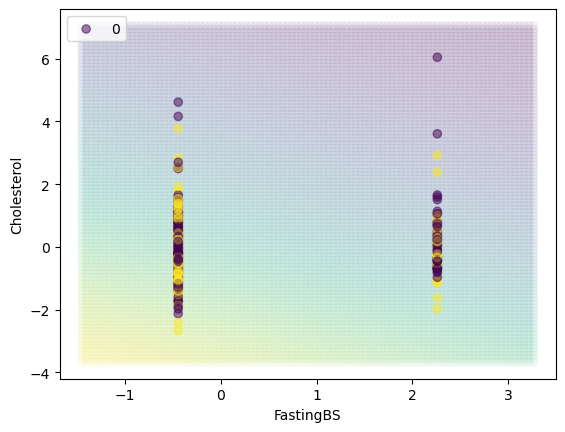

In [346]:
# ロジスティック回帰

logi = LogisticRegression(C=1, solver='lbfgs', penalty='l2')
# logi = LogisticRegression(C=0.1, solver='liblinear', penalty='l1')
logi.fit(X_train_ss, y_train)

print('学習用データでの正解率:', (logi.predict(X_train_ss) == y_train).mean())
print('切片:', logi.intercept_)
display(pd.DataFrame({'変数名': cols, '係数': logi.coef_[0]}))
print('係数:', logi.coef_)
print(cols)

xx, yy = np.meshgrid(np.linspace(start=min(X_train_ss[:, 0]) - 1, stop=max(X_train_ss[:, 0]) + 1, num=100), np.linspace(start=min(X_train_ss[:, 1]) - 1, stop=max(X_train_ss[:, 1]) + 1, num=100))

X_test_ss = np.c_[xx.ravel(), yy.ravel()]
y_prob = logi.predict_proba((X_test_ss))

plt.scatter(X_test_ss[:, 0], X_test_ss[:, 1], c=y_prob[:, 1], alpha=0.05)
plt.scatter(x=X_train_ss[:, 0], y=X_train_ss[:, 1], c=y_train, label=y_train[0], alpha=0.5)
plt.xlabel(cols[0]) 
plt.ylabel(cols[1])
plt.legend(loc="upper left")
plt.show()